Retrieval-Augmented Generation for Contracts

In [1]:
#Imports
!pip install sentence-transformers pypdf matplotlib
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

import numpy as np
from sentence_transformers import SentenceTransformer
from pypdf import PdfReader
import matplotlib.pyplot as plt
#from openai import OpenAI - for LLM plugin later on
#Client = OpenAI()

In [2]:
#Configuration
#Folder containing your sample contracts (PDF or TXT).
#Change folder or path if neeeded
CONTRACTS_DIR = Path(r"C:\\Users\\JeJones\\Desktop\\Final")

#Chunking parameters: how big each text chunk should be and how much they overlap.
CHUNK_SIZE = 800     # approximate number of characters per chunk
CHUNK_OVERLAP = 200  # overlap between consecutive chunks

#Embedding model: small, fast, and local (no API key needed).
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

In [3]:
#Helpers
def load_text_from_pdf(file_path: Path) -> str:
    #Extract text from a PDF file using pypdf.
    reader = PdfReader(str(file_path))
    text_pages = []
    for page in reader.pages:
        try:
            text_pages.append(page.extract_text() or "")
        except Exception:
            text_pages.append("")
    return "\n".join(text_pages)


def load_text_from_txt(file_path: Path) -> str:
    #Load plain text from a .txt file
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()


def load_contracts_from_folder(root_dir: Path) -> List[Dict[str, Any]]:
    #Walk through root_dir and load all .pdf and .txt contracts.
    #Return a list of dicts with { 'file_path': ..., 'text': ... }.
    contracts = []
    if not root_dir.exists():
        print(f"WARNING: contracts directory {root_dir} does not exist yet.")
        return contracts

    for path in root_dir.rglob("*"):
        text = ""
        if path.suffix.lower() == ".pdf":
            text = load_text_from_pdf(path)
        elif path.suffix.lower() == ".txt":
            text = load_text_from_txt(path)
        else:
            continue  # skip unsupported file types for now

        if text.strip():
            contracts.append({
                "file_path": path,
                "text": text
            })
    return contracts

In [4]:
#Chunking and Corpus Construction
def chunk_text(text: str,
               chunk_size: int = CHUNK_SIZE,
               chunk_overlap: int = CHUNK_OVERLAP) -> List[str]:
    #Simple character-based chunker.
    #In a more advanced version, I would split on headings or paragraphs

    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start += chunk_size - chunk_overlap
    return chunks


def build_corpus(contracts: List[Dict[str, Any]]) -> List[Dict[str, Any]]:

    #Convert contracts into a list of chunk-level records.
    #Each record has:
      #chunk_id
      #file_path
      #chunk_text
    
    corpus = []
    chunk_id = 0
    for c in contracts:
        file_path = c["file_path"]
        text = c["text"]
        chunks = chunk_text(text)
        for ch in chunks:
            corpus.append({
                "chunk_id": chunk_id,
                "file_path": file_path,
                "chunk_text": ch
            })
            chunk_id += 1
    return corpus


def visualize_chunk_lengths(corpus: List[Dict[str, Any]]):
    #Plot a simple histogram of chunk lengths (in characters).
    if not corpus:
        print("No chunks to visualize.")
        return

    lengths = [len(entry["chunk_text"]) for entry in corpus]

    plt.figure()
    plt.hist(lengths, bins=20)
    plt.xlabel("Chunk length (characters)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Chunk Lengths")
    plt.show()

In [5]:
#Embeddings and Simple Vector Index
#A very simple in-memory vector index.
#Stores embeddings in a matrix and supports cosine similarity search.

from typing import List, Dict, Any, Tuple
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer


class SimpleVectorIndex:
    """
    A very simple in-memory vector index.
    Stores embeddings in a matrix and supports cosine similarity search.
    """

    def __init__(self, model_name: str):
        # Load embedding model (this may take a few seconds the first time).
        self.model = SentenceTransformer(model_name)
        self.embeddings = None  # numpy array of shape (N, D)
        self.metadata: List[Dict[str, Any]] = []

    def build(self, corpus: List[Dict[str, Any]]):
        """Build the index from a list of { 'chunk_text', ... } records."""
        texts = [entry["chunk_text"] for entry in corpus]
        if not texts:
            print("No texts provided to build the index.")
            return

        print(f"Computing embeddings for {len(texts)} chunks...")
        vectors = self.model.encode(texts, show_progress_bar=True)
        self.embeddings = np.array(vectors)
        self.metadata = corpus
        print("Index built.")

    def search(self, query: str, top_k: int = 5) -> List[Tuple[Dict[str, Any], float]]:
        """
        Search for the most relevant chunks to the given query.
        Returns a list of (metadata_dict, similarity_score).
        """
        if self.embeddings is None or not len(self.metadata):
            raise ValueError("Index not built or empty. Call build() first.")

        #Encode and normalize query vector
        query_vec = self.model.encode([query])[0]
        qnorm = np.linalg.norm(query_vec)
        if qnorm == 0:
            raise ValueError("Query embedding norm is zero; cannot compute cosine similarity.")
        query_vec = query_vec / qnorm

        #Normalize stored embeddings (guard against zero-norm rows)
        norms = np.linalg.norm(self.embeddings, axis=1, keepdims=True)
        norms[norms == 0] = 1.0  # avoid division by zero
        normalized_embeddings = self.embeddings / norms

        #Cosine similarity
        scores = normalized_embeddings @ query_vec
        top_indices = np.argsort(-scores)[:top_k]

        results: List[Tuple[Dict[str, Any], float]] = []
        for idx in top_indices:
            meta = self.metadata[idx]
            sim = float(scores[idx])
            results.append((meta, sim))
        return results

    def visualize_similarity_scores(self, results: List[Tuple[Dict[str, Any], float]]):
        #Bar chart of similarity scores for the top retrieved chunks.
        if not results:
            print("No results to visualize.")
            return

        scores = [score for (_, score) in results]
        labels = [f"Chunk {meta.get('chunk_id', idx)}" for idx, (meta, _) in enumerate(results)]

        x = np.arange(len(scores))

        plt.figure()
        plt.bar(x, scores)
        plt.xticks(x, labels, rotation=45, ha="right")
        plt.ylabel("Cosine similarity")
        plt.title("Top Retrieved Chunks - Similarity Scores")
        plt.tight_layout()
        plt.show()

In [6]:
#Placeholder for answer generation
def format_context(chunks: List[Dict[str, Any]]) -> str:
    #Combine retrieved chunks into a context string.
    parts = []
    for i, ch in enumerate(chunks, start=1):
        parts.append(f"--- Source {i} ({ch['file_path']}):\n{ch['chunk_text']}\n")
    return "\n".join(parts)


def answer_question_with_context(query: str,
                                 retrieved: List[Tuple[Dict[str, Any], float]]) -> str:
    
    #Placeholder "generation" step.
    #Right now, just returns the question and the retrieved context.

    #In a real system, you'd call a language model here (e.g., OpenAI API)
    #with: the user query, the formatted context

    #and ask it to summarize the relevant clauses and highlight key points.

    top_chunks = [meta for (meta, score) in retrieved]

    context = format_context(top_chunks)

    answer = f"QUESTION:\n{query}\n\nRETRIEVED CONTEXT:\n{context}"
    return answer

In [7]:
#End to end helpers
def build_contractrag_index(contracts_dir: Path = CONTRACTS_DIR) -> Tuple[SimpleVectorIndex, List[Dict[str, Any]]]:
    #Full pipeline: Load contracts from directory, Build corpus, Build vector index
    #Returns the index and the corpus.
    
    print(f"Loading contracts from: {contracts_dir}")
    contracts = load_contracts_from_folder(contracts_dir)
    print(f"Loaded {len(contracts)} contracts.")

    corpus = build_corpus(contracts)
    print(f"Corpus created with {len(corpus)} chunks.")

    index = SimpleVectorIndex(EMBEDDING_MODEL_NAME)
    index.build(corpus)
    return index, corpus


def ask_contractrag(index: SimpleVectorIndex, query: str, top_k: int = 5) -> Tuple[str, List[Tuple[Dict[str, Any], float]]]:
    #High-level inquiry function for ContractRAG
    results = index.search(query, top_k=top_k)
    answer = answer_question_with_context(query, results)
    return answer, results

Loading contracts from: C:\Users\JeJones\Desktop\Final
Loaded 2 contracts.
Corpus created with 343 chunks.
Computing embeddings for 343 chunks...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Index built.


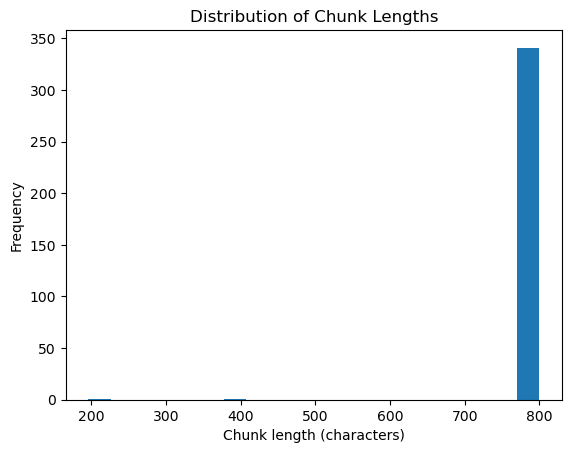

In [8]:
#Build the index and visualize chunk lengths
index, corpus = build_contractrag_index(CONTRACTS_DIR)

#Visualize how long the chunks are.
visualize_chunk_lengths(corpus)

QUESTION:
indemnification

RETRIEVED CONTEXT:
--- Source 1 (C:\Users\JeJones\Desktop\Final\Contracts\Granular Activated Carbon Exhange and Vessel Appurtenances -ReBid Package -FINAL.pdf):
 the obligation to comply with the Act and to defend, 
indemnify, protect, and save harmless the Owner pursuant to this paragraph. 
 
It is further agreed and understood that the Owner assumes no obligation to indemnify or save harmless the 
contractor, its agents, servants, employees and subcontractors for any claim that may arise out of their 
performance of this Agreement.  Furthermore, the contractor expressly understands and agrees that the 
provisions of this indemnification clause shall in no way limit the contractor’s obligations assumed in this 
Agreement, nor shall they be construed to relieve the contractor from any liability, nor preclude the Owner 
from taking any other actions available to it under any other provisions of this Agreement or otherwise at law. 
 
Name of Bidder 

--- Source

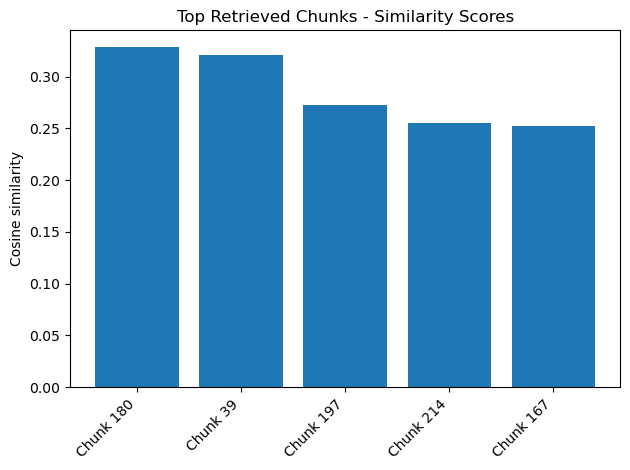

In [10]:
#Ask simple question adn visualize similarities scores

sample_query = "indemnification"
answer, results = ask_contractrag(index, sample_query, top_k=5)

#Print raw answer with retrieved context (for inspection)
print(answer[:2000])  #truncate for display if long

#Visualize similarity scores for the retrieved chunks
index.visualize_similarity_scores(results)